In [333]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import ParameterGrid

In [334]:
# define evaluation metrics for volatility forecasting
def rmse_var(y_true, y_pred):
    # convert log-vol to variance
    y_true_var = np.exp(2 * y_true)
    y_pred_var = np.exp(2 * y_pred)
    return float(np.sqrt(np.mean((y_true_var - y_pred_var) ** 2)))

def qlike_var(y_true, y_pred, eps=1e-12):
    y_true_var = np.exp(2 * y_true)
    y_pred_var = np.exp(2 * y_pred)
    ratio = (y_true_var + eps) / (y_pred_var + eps)
    return float(np.mean(ratio - np.log(ratio) - 1.0))


### Building XGBoost

In [335]:
btc_df = pd.read_csv('../Data/btc_final_df.csv')

In [336]:
def time_series_train_test_split(df, train_size=0.85, purge_hours=1):

    n = len(df)
    train_end = int(n * train_size)
    purge = int(purge_hours)
    train = df.iloc[:train_end].copy()
    test = df.iloc[train_end + purge:].copy()
    print(f"Train samples: {len(train)}, Test samples: {len(test)}")
    return train, test

In [337]:
def rolling_splits_with_val(df, target_col, n_splits=5, purge_hours=1, val_ratio=0.15, test_size=120):

    if target_col not in df.columns:
        raise ValueError(f"{target_col} not in df.columns")

    df = df.sort_index()
    X = df.drop(columns=[target_col])
    y = df[[target_col]]

    n = len(df)
    train_size = n - (purge_hours + n_splits * test_size)

    if train_size <= 0:
        raise ValueError("Not enough data for given n_splits, purge_hours, and test_size.")

    splits = []
    start_train = 0

    for k in range(n_splits):
        end_train = start_train + train_size
        start_test = end_train + purge_hours
        end_test = start_test + test_size

        if end_test > n:
            break

        val_size = max(1, int(train_size * val_ratio))
        train_cut = end_train - val_size

        train_idx = np.arange(start_train, train_cut)
        val_idx = np.arange(train_cut, end_train)
        test_idx = np.arange(start_test, end_test)

        X_train, y_train = X.iloc[train_idx].copy(), y.iloc[train_idx].copy()
        X_val, y_val = X.iloc[val_idx].copy(), y.iloc[val_idx].copy()
        X_test, y_test = X.iloc[test_idx].copy(), y.iloc[test_idx].copy()

        splits.append((X_train, X_val, X_test, y_train, y_val, y_test))
        start_train += test_size

    return splits

In [338]:
def split_train_test(df, train_size=0.85, purge_hours=1):
    return time_series_train_test_split(df, train_size=train_size, purge_hours=purge_hours)


In [339]:
def tune_model_cv(train_df, features, target='vol_future',
                  param_grid=None, n_splits=5, purge_hours=1, val_ratio=0.15, test_size=120):

    print(f"\nTuning hyperparameters with rolling CV ({n_splits} folds, {purge_hours}h purge, val_ratio={val_ratio})...")

    if param_grid is None:
        param_grid = {
            'max_depth': [2, 3, 5],
            'learning_rate': [0.0001, 0.01, 0.05, 0.1],
            'n_estimators': [200, 400],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }

    train_df = train_df.sort_values("timestamp").reset_index(drop=True)
    df_model = train_df[features + [target]]

    splits = rolling_splits_with_val(df_model, target_col=target,
                                     n_splits=n_splits, purge_hours=purge_hours,
                                     val_ratio=val_ratio, test_size=test_size)

    best_score = np.inf
    best_params = None
    results = []

    for params in ParameterGrid(param_grid):
        fold_scores = []
        for (X_train, X_val, _, y_train, y_val, _) in splits:
            model = XGBRegressor(random_state=42, n_jobs=-1, **params)
            model.fit(X_train, y_train.values.ravel(), verbose=False)
            y_pred = model.predict(X_val)
            rmse = np.sqrt(np.mean((y_val.values.ravel() - y_pred) ** 2))
            fold_scores.append(rmse)

        mean_rmse = np.mean(fold_scores)
        results.append({'params': params, 'mean_rmse': mean_rmse})
        if mean_rmse < best_score:
            best_score = mean_rmse
            best_params = params

    results_df = pd.DataFrame(results).sort_values('mean_rmse').reset_index(drop=True)
    print("Best tuned parameters:", best_params)
    print(f"Best CV RMSE: {best_score:.6f}")
    return best_params, results_df


In [340]:
def train_and_test(df, features, target='vol_future', param_grid=None):
    train_df, test_df = split_train_test(df)

    # Step 1: Tune hyperparameters with rolling CV
    best_params, results_df = tune_model_cv(train_df, features, target, param_grid)

    # Step 2: Retrain on full training data
    print("\nRetraining final model on full training data with tuned parameters...")
    X_train, y_train = train_df[features], train_df[target]
    final_model = XGBRegressor(**best_params, random_state=42, n_jobs=-1)
    final_model.fit(X_train, y_train, verbose=False)

    # Step 3: Evaluate on hold-out test set
    print("\nEvaluating on final test set...")
    X_test, y_test = test_df[features], test_df[target]
    y_pred = final_model.predict(X_test)

    rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
    ql = qlike_var(y_test, y_pred)

    print(f"Test Results — QLIKE: {ql:.6f}, RMSE: {rmse:.6f}")

    predictions_df = test_df[['timestamp', target]].copy()
    predictions_df['pred_vol_future'] = y_pred
    return final_model, best_params, results_df, predictions_df


In [341]:
# Ensure timestamp is datetime
btc_df['timestamp'] = pd.to_datetime(btc_df['timestamp'])

# Feature columns
features = [c for c in btc_df.columns if c not in ['timestamp', 'vol_future']]

# Train, tune, and test
model, best_params, cv_results, predictions_df = train_and_test(btc_df, features)

Train samples: 6976, Test samples: 1231

Tuning hyperparameters with rolling CV (5 folds, 1h purge, val_ratio=0.15)...
Best tuned parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 200, 'subsample': 0.8}
Best CV RMSE: 0.306570

Retraining final model on full training data with tuned parameters...

Evaluating on final test set...
Test Results — QLIKE: 1.072592, RMSE: 0.468479


### Plotting of results and Feature importance

In [342]:
## importing libraries
import matplotlib.pyplot as plt


In [343]:

def plot_predicted_vs_actual(predictions_df, title="Predicted vs Actual Volatility (Test Set)"):
    """
    Plot predicted vs actual volatility for the test set.
    """
    plt.figure(figsize=(12, 5))
    plt.plot(predictions_df['timestamp'], predictions_df['vol_future'], label='Actual Volatility', linewidth=2)
    plt.plot(predictions_df['timestamp'], predictions_df['pred_vol_future'], label='Predicted Volatility', linewidth=2, linestyle='--')
    
    plt.title(title, fontsize=14)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Volatility", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


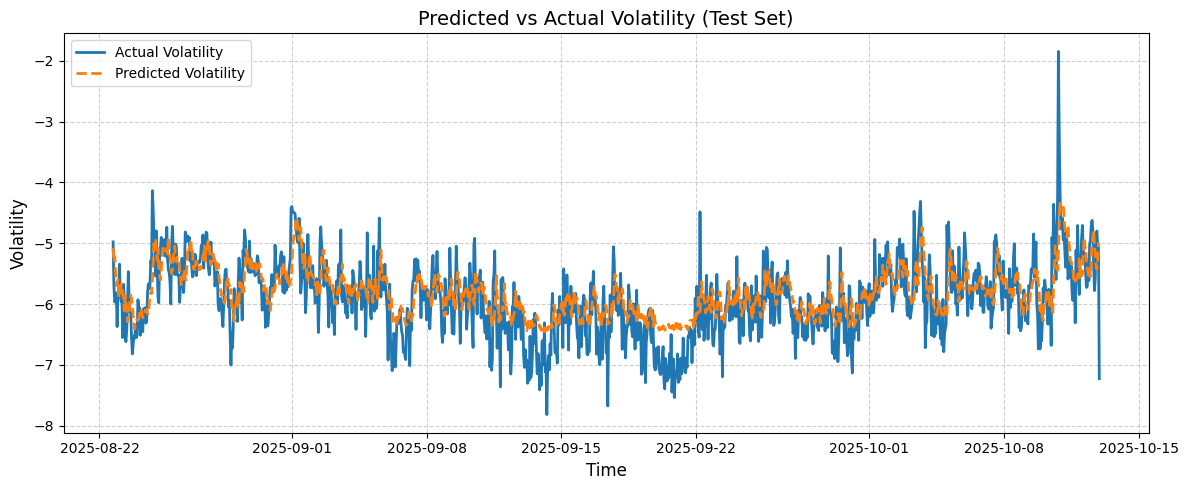

In [344]:
# Plot results
plot_predicted_vs_actual(predictions_df)


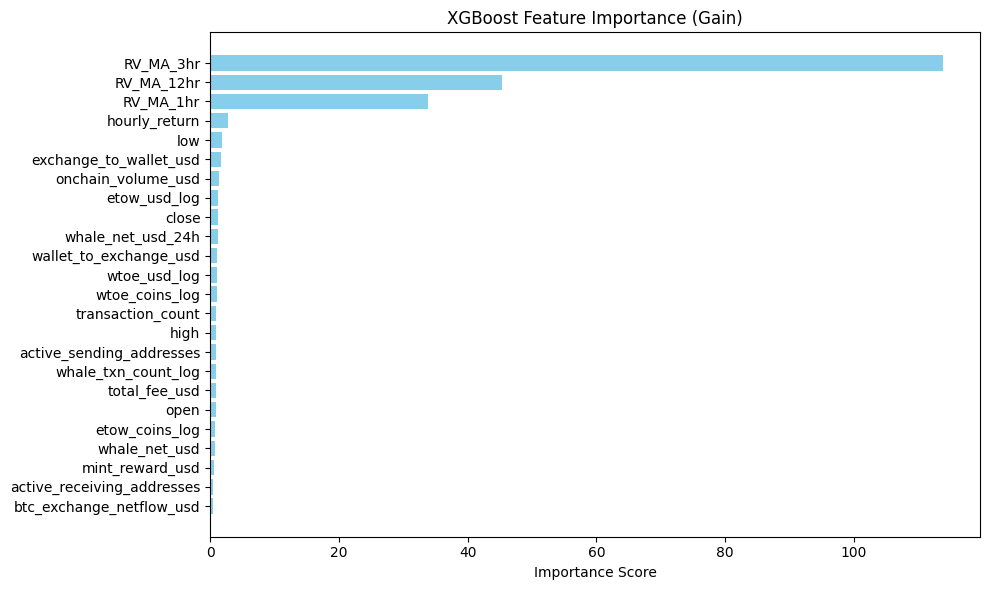

In [345]:
importance = model.get_booster().get_score(importance_type='gain')
importance_df = (
    pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])
    .sort_values('Importance', ascending=True)
)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title("XGBoost Feature Importance (Gain)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


In [346]:
predictions_df.to_csv('../Results/btc_xgb_prediction.csv', index=False)